In [42]:
import requests # HTTP
import pandas as pd # managing the data
import numpy as np # mathematical operations
import seaborn as sns # visualizing the data
import matplotlib.pyplot as plt # additional plotting tools

# sklearn for machine learning and machine-learning-pipeline related functions.
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Task 1 : Import the dataset


In [43]:
filepath = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/medical_insurance_dataset.csv'
filename = 'insurance_cost.csv'

getFile = requests.get(filepath)
getFile.raise_for_status()

with open(filename, 'wb') as f:
  f.write(getFile.content)

df = pd.read_csv(filename, header=None)
df.head(10)

,0,1,2,3,4,5,6
0,19,1,27.900,0,1,3,16884.92400
1,18,2,33.770,1,0,4,1725.55230
2,28,2,33.000,3,0,4,4449.46200
3,33,2,22.705,0,0,1,21984.47061
4,32,2,28.880,0,0,1,3866.85520
5,31,1,25.740,0,?,4,3756.62160
6,46,1,33.440,1,0,4,8240.58960
7,37,1,27.740,3,0,1,7281.50560
8,37,2,29.830,2,0,2,6406.41070
9,60,1,25.840,0,0,1,28923.13692


In [44]:
headers = ['Age', 'Gender', 'Body_mass_index', 'Num_of_children', 'Smoker', 'Region', 'Charges']
df.columns = headers
df.replace('?', np.nan, inplace = True) # replace the '?' entries with 'NaN' values.
df.head(10)

,Age,Gender,Body_mass_index,Num_of_children,Smoker,Region,Charges
0,19,1,27.900,0,1,3,16884.92400
1,18,2,33.770,1,0,4,1725.55230
2,28,2,33.000,3,0,4,4449.46200
3,33,2,22.705,0,0,1,21984.47061
4,32,2,28.880,0,0,1,3866.85520
5,31,1,25.740,0,NaN,4,3756.62160
6,46,1,33.440,1,0,4,8240.58960
7,37,1,27.740,3,0,1,7281.50560
8,37,2,29.830,2,0,2,6406.41070
9,60,1,25.840,0,0,1,28923.13692


# Task 2 : Data Wrangling

In [45]:
print(df.info()) # check null ? -> Age & Smoker have NaN values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              2768 non-null   object 
 1   Gender           2772 non-null   int64  
 2   Body_mass_index  2772 non-null   float64
 3   Num_of_children  2772 non-null   int64  
 4   Smoker           2765 non-null   object 
 5   Region           2772 non-null   int64  
 6   Charges          2772 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 151.7+ KB
None


In [58]:
# Handle missing data

# Thay Nan của Age thành Age trung bình và age ->	integer
# Chuyển kiểu object của Age-> float trc khi tính average vì nó sẽ tự động bỏ qua các gitr NaN khi tính toán trung bình
average_age = df['Age'].astype('float').mean(axis=0)
df['Age'].replace(np.nan, average_age)
df['Age'] = df['Age'].astype('int')

# gender ->	Male (1) / Female (2)
invalid_gender_rows = df[(df['Gender'] != 1) & (df['Gender'] != 2)]
print(invalid_gender_rows.empty)

# region -> NW, NE, SW, SE (1,2,3 or 4)
valid_regions = [1, 2, 3, 4]
invalid_region_rows = df[~df['Region'].isin(valid_regions)]
print(invalid_region_rows.empty)

# bmi	- float OK
# no_of_children - int OK

# smoker
smoke_status = df['Smoker'].value_counts()
print(smoke_status)
is_smoke = smoke_status.idxmax()
df['Smoker'] = df['Smoker'].replace(np.nan, is_smoke).astype('int')

# charges	-	float round 2 decimal places
df['Charges'] = df['Charges'].round(2)

print(df.info())

True
True
Smoker
0    2208
1     564
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              2772 non-null   int64  
 1   Gender           2772 non-null   int64  
 2   Body_mass_index  2772 non-null   float64
 3   Num_of_children  2772 non-null   int64  
 4   Smoker           2772 non-null   int64  
 5   Region           2772 non-null   int64  
 6   Charges          2772 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 151.7 KB
None


# Task 3 : Exploratory Data Analysis (EDA)

(0.0, 66902.85800000001)

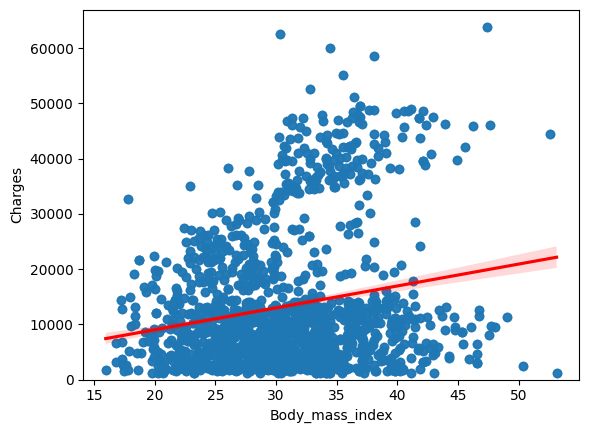

In [66]:
# Tạo một biểu đồ hồi quy
sns.regplot(x="Body_mass_index", y="Charges", data=df, line_kws={"color": "red"})
plt.ylim(0,)

<Axes: xlabel='Smoker', ylabel='Charges'>

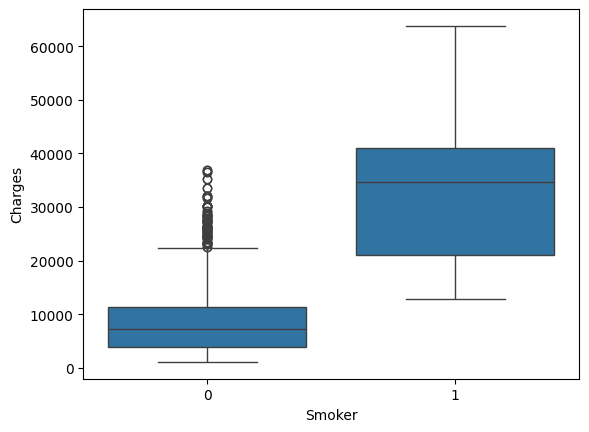

In [70]:
sns.boxplot(x="Smoker", y="Charges", data=df)

In [74]:
# the correlation matrix for the dataset
rounded_correlation_matrix = df.corr().round(3)
rounded_correlation_matrix
# Charges - Smoker (0.789) -> Người hút thuốc có xu hướng có chi phí bảo hiểm cao hơn

,Age,Gender,Body_mass_index,Num_of_children,Smoker,Region,Charges
Age,1.000,-0.026,0.113,0.038,-0.023,-0.007,0.299
Gender,-0.026,1.000,0.043,0.016,0.082,0.022,0.063
Body_mass_index,0.113,0.043,1.000,-0.001,0.011,0.271,0.200
Num_of_children,0.038,0.016,-0.001,1.000,0.006,-0.026,0.066
Smoker,-0.023,0.082,0.011,0.006,1.000,0.054,0.789
Region,-0.007,0.022,0.271,-0.026,0.054,1.000,0.054
Charges,0.299,0.063,0.200,0.066,0.789,0.054,1.000


# Task 4 : Model Development

In [128]:
# Fit a linear regression model
# predict the charges value, just by using the smoker attribute
x_smoke = df[['Smoker']]
y_charges = df['Charges']

lr = LinearRegression()
lr.fit(x_smoke, y_charges)
lr.coef_
lr.intercept_

yhat_charges = lr.predict(x_smoke)
yhat_charges[0:5]
print(lr.score(x_smoke, y_charges))

0.6221791733924185


In [95]:
# using all other attributes of the dataset
x_all = df[['Age', 'Gender', 'Body_mass_index', 'Num_of_children', 'Smoker', 'Region']]
lr.fit(x_all, y_charges)
print(lr.score(x_all, y_charges))

0.7504083820289634


In [109]:
# Create a training pipeline
# danh sách các bước: StandardScaler(), PolynomialFeatures() and LinearRegression()
Input = [('scale', StandardScaler()), ('polynomial', PolynomialFeatures(include_bias=False)), ('model', LinearRegression())]
pipe = Pipeline(Input)

x_all = x_all.astype(float)
pipe.fit(x_all, y_charges)
ypipe=pipe.predict(x_all)

print(r2_score(y_charges, ypipe)) #print(pipe.score(x_all, y_charges))

0.8452576213500093


In [110]:
# Task 4 maybe Overfit & Multicollinearity ? -> Task 5

# Task 5 : Model Refinement

In [118]:
# Split, assuming that 20% testing.
x_train, x_test, y_train, y_test = train_test_split(x_all, y_charges, test_size=0.2, random_state=1)
print(x_train.shape)
print(x_test.shape)

# hyperparameter = 0.1
rd = Ridge(0.1)
rd.fit(x_train, y_train)
yhat = rd.predict(x_test)
print(r2_score(y_test, yhat))

(2217, 6)
(555, 6)
0.6760807731582404


In [120]:
# kết hợp PolynomialFeatures với Ridge Regression
pr = PolynomialFeatures(degree=2) # bậc của đa thức
x_train_pr = pr.fit_transform(x_train) # fit_transform
x_test_pr = pr.transform(x_test) # transform

rd.fit(x_train_pr, y_train)
y_hat = rd.predict(x_test_pr)
print(r2_score(y_test,y_hat))

0.783563110760815
